Attempting a seasonal comparison at different depths between model and ONC data.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
import netCDF4 as nc
import pandas as pd
import numpy as np
import os

from salishsea_tools import viz_tools

import ONC_patrols as onc

%matplotlib inline

/home/nsoontie/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_color_codes()

In [3]:
badQC = [0,3,4,9]
files = glob.glob('/ocean/nsoontie/MEOPAR/ONC/Patrols/*.csv')
cols = sns.color_palette("hls", len(files))
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

In [4]:
def seasonal_cycle(data, depth_range, field):
    """Group data into months and apply mean/min/max to field in depth range given by drange. """
    
    data_depth = data[(data['Depth Corrected (m)'] >= depth_range[0]) & 
                      (data['Depth Corrected (m)'] <= depth_range[1])]
    
    grouped = data_depth.groupby([data['day'].dt.year, data['day'].dt.month])
    
    months=[]
    means=[]
    mins=[]
    maxes=[]
    for month, group in grouped:
        months.append(datetime.datetime(month[0],month[1],15))
        means.append(group[field].mean())
        mins.append(group[field].min())
        maxes.append(group[field].max())
    return months, np.array(means), np.array(maxes), np.array(mins)

# Observed Seasonal cycles (like Rich's plots)

(48, 51)

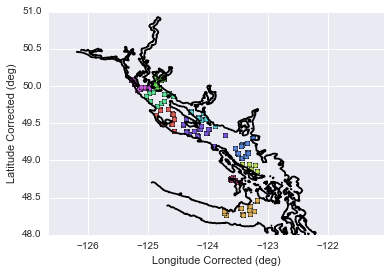

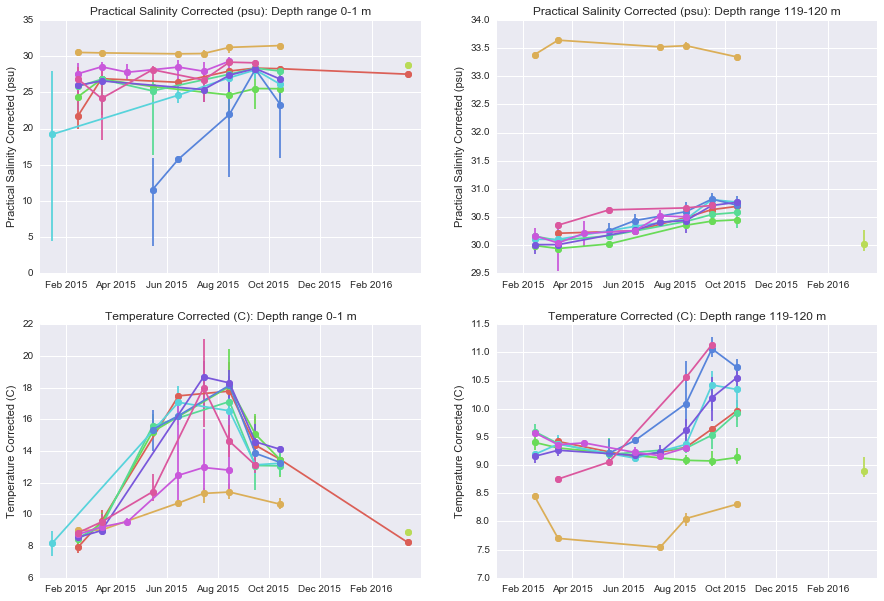

In [5]:
fig,axm = plt.subplots(1,1)
fig,axs = plt.subplots(2,2,figsize=(15,10))
c=0
fields = ['Practical Salinity Corrected (psu)',
         'Temperature Corrected (C)']
dranges = [ (0,1), (119,120)]
for file in files:
    data = onc.load_patrol_csv(file)
    data = onc.exclude_bad(data,['Practical Salinity Corrected QC Flag  '], badQC)
    for field, ax_c in zip(fields,axs):
        for drange, ax in zip(dranges, ax_c):
            months, means,maxes,mins = seasonal_cycle(data,drange,field)
            yerr = [means-mins, maxes-means]
            ax.plot(months, means,'o-',color=cols[c])
            ax.errorbar(months, means, yerr=yerr, color=cols[c], fmt='o')
            ax.set_ylabel(field)
            ax.set_title('{}: Depth range {}-{} m'.format(field,drange[0],drange[1]))
            ax.set_xlim([datetime.datetime(2015,1,1),datetime.datetime(2016,3,31)])
    
    data.plot(x='Longitude Corrected (deg)',y='Latitude Corrected (deg)',kind='scatter',ax=axm,c=cols[c])
    c=c+1

viz_tools.plot_coastline(axm,grid_B,coords='map')
axm.set_ylim([48,51])

# Model Comparison
Idea: for each cast, look up model cast but average over area, depth range and month.

In [6]:
def model_obs_data_frame(data, model_field, obs_field):
    """Build model data frame of daily mean, max, min of equivalent casts in observed data frame"""
    
    model_obs_data = pd.DataFrame({'day':[], 'Model Mean':[],
                               'Model Max':[],'Model Min':[],
                               'Depth Corrected (m)':[],
                               'obs': []})
    data_days, days = onc.list_days(data)
    for d in days:
        daily = data_days.get_group(d).dropna()
        daily_casts = daily.groupby('Cast')
        for c in daily_casts.groups:
            cast = daily_casts.get_group(c)
            lat, lon, date = onc.cast_position_and_time(cast)
            obs_depth = np.array(cast['Depth Corrected (m)'][:])
            try:
                model_d_interp, model_max, model_min = onc.retrieve_nowcast_data(
                    lon, lat, date, obs_depth, model_field, grid_B, mesh_mask)
                day_list = [date for i in range(model_d_interp.shape[0])]
                sub_data = pd.DataFrame({'day': day_list,
                                        'Model Mean': model_d_interp,
                                        'Model Max': model_max,
                                        'Model Min': model_min,
                                        'Depth Corrected (m)': obs_depth,
                                        'obs': np.array(cast[obs_field]),
                                        'Longitude Corrected (deg)':  np.array(cast['Longitude Corrected (deg)']),
                                        'Latitude Corrected (deg)':  np.array(cast['Latitude Corrected (deg)'])})
                model_obs_data = model_obs_data.append(sub_data,ignore_index=True)
            except IndexError:
                print(
                    'No Model Point for {} {}'.format(
                        cast['Longitude Corrected (deg)'].mean(),
                        cast['Latitude Corrected (deg)'].mean()))
    return model_obs_data


In [7]:
def process_all_model_obs_dict(files, model_field, obs_field):
    """Create model-obs dictionary of data for all files listed in files."""
    
    storage_dict = {}
    
    for file in files:
        data = onc.load_patrol_csv(file)
        data = onc.exclude_bad(data,['Practical Salinity Corrected QC Flag  '], badQC)
        data_cast = onc.divide_into_casts(data)
        key = os.path.basename(file).split('_')[0]

        model_obs_data = model_obs_data_frame(data_cast, model_field, obs_field)

        storage_dict[key] = model_obs_data
    return storage_dict

In [8]:
def fake_legend(ax):
    """Add a legend for model --s and obs -o"""
    lo,=ax.plot([0,0],[0,0],'o-',color='gray')
    lm,=ax.plot([0,0],[0,0],'s--',color='gray')
    ax.legend([lo,lm],['obs','model'])

In [9]:
def plot_seasonal_trend(data_region, drange, ax, color):
    """plot the observed/modelled seasonal trends stored in data_region"""    
    obs_months, obs_means,_,_ = seasonal_cycle(data_region,drange,'obs')
    months, means,_,_ = seasonal_cycle(data_region,drange,'Model Mean')
    months, maxes,max_max,_ = seasonal_cycle(data_region,drange,'Model Max')
    months, mins,_,min_min  = seasonal_cycle(data_region,drange,'Model Min')
    ax.plot(obs_months, obs_means,'o-',color=color,label='obs')
    ax.plot(months, maxes,'s--',color='gray',label='model max')
    ax.plot(months, mins,'s:',color='gray',label='model min')

## Salinity

In [10]:
data_dict =  process_all_model_obs_dict(files, 'vosaline', 'Practical Salinity Corrected (psu)')

No Model Point for -124.86734926829268 49.60367543902441
No Model Point for -124.66473445454545 49.692539545454544
No Model Point for -123.30147711249997 48.334551287500005
No Model Point for -123.30579209999999 48.33254605
No Model Point for -123.18295900000003 48.461194
No Model Point for -123.44497209090906 48.3592954090909
No Model Point for -124.88309081132078 50.133188216981125
No Model Point for -124.88435187999998 50.02145567333332
No Model Point for -124.88373059333328 50.021488919999996
No Model Point for -124.8813384326241 50.13317171631203
No Model Point for -124.8818940066667 50.133191646666674
No Model Point for -124.92035517333338 49.92162987333333
No Model Point for -124.85466473333334 49.73138674999999
No Model Point for -124.92043986092716 49.92159999999987
No Model Point for -124.72611825675678 49.80339318243243
No Model Point for -124.92015144000004 49.921603720000014
No Model Point for -124.92028950335572 49.92159999999987
No Model Point for -124.15602561589404 49.

### Overview

In [11]:
def plot_overview(obs_field, data_dict, dranges, lims, cols, grid_B,files):
    """Plot an overview of seasonal trends in data_dict at depth ranges listed in dranges.
    Compare model and observations."""
    
    fig,axm = plt.subplots(1,1)
    fig,axs = plt.subplots(1,len(dranges),figsize=(20,5))

    c=0 
    for file in files:
        key = os.path.basename(file).split('_')[0]
        data_region = data_dict[key]
        for drange, ax,ylim in zip(dranges, axs,lims):
            obs_months, obs_means, _,_ = seasonal_cycle(data_region,drange,'obs')
            months, means,_,_ = seasonal_cycle(data_region,drange,'Model Mean')
            ax.plot(obs_months, obs_means,'o-',color=cols[c])
            ax.plot(months, means,'s--',color=cols[c])
            ax.set_ylabel(obs_field)
            ax.set_title('{}: Depth range {}-{} m'.format(obs_field,drange[0],drange[1]))
            ax.set_xlim([datetime.datetime(2015,1,1),datetime.datetime(2016,3,31)])
            plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
            fake_legend(ax)
            ax.set_ylim(ylim)

        data_region.plot(x='Longitude Corrected (deg)',y='Latitude Corrected (deg)',kind='scatter',ax=axm,c=cols[c])
        c=c+1

    viz_tools.plot_coastline(axm,grid_B,coords='map')
    axm.set_ylim([48,51])

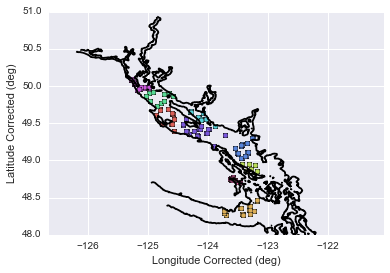

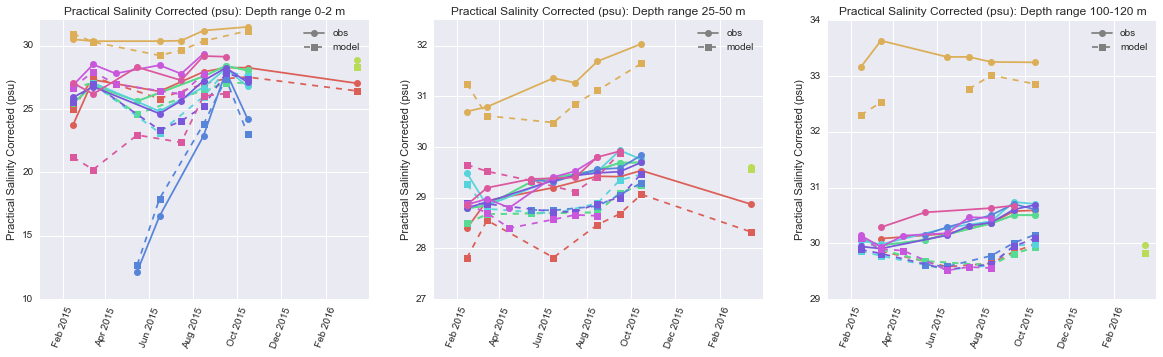

In [12]:
obs_field = 'Practical Salinity Corrected (psu)'
dranges = [ (0,2), (25,50), (100,120)]
lims=[(10,32), (27,32.5), (29,34)]

plot_overview(obs_field, data_dict, dranges, lims, cols, grid_B,files)

### Region by Region

In [13]:
def plot_region_by_region(obs_field, data_dict, dranges, lims, cols,files):
    """Compare model and observed seasonal trends in depth ranges region by region."""
    c=0 
    for file in files:
        fig,axs = plt.subplots(1,len(dranges),figsize=(20,3))
        key = os.path.basename(file).split('_')[0]
        data_region = data_dict[key]
        for drange, ax, ylim in zip(dranges, axs,lims):
            plot_seasonal_trend(data_region, drange, ax, cols[c])
            ax.set_ylabel(obs_field)
            ax.set_title('{}: Depth range {}-{} m'.format(key,drange[0],drange[1]))
            ax.set_xlim([datetime.datetime(2015,1,1),datetime.datetime(2016,3,31)])
            ax.set_ylim(ylim)
            ax.legend(loc=4)
            plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )

        c=c+1

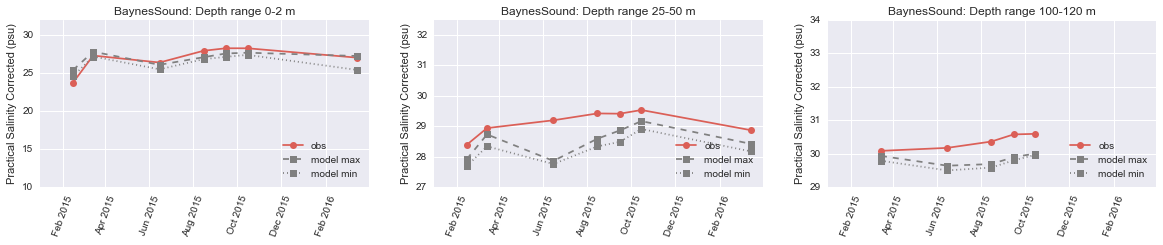

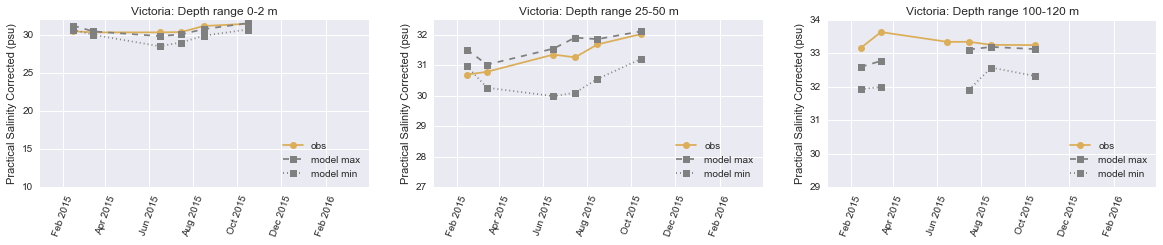

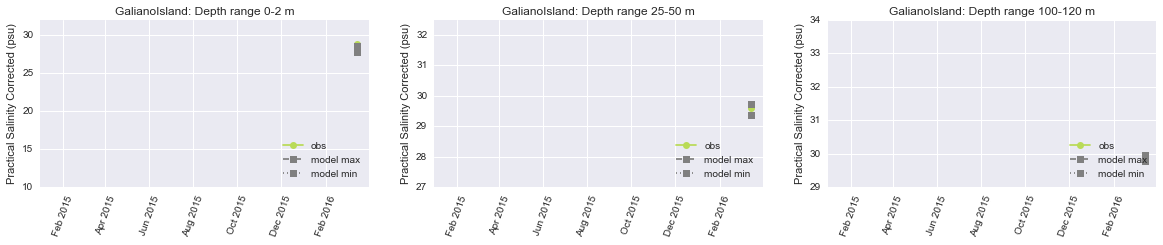

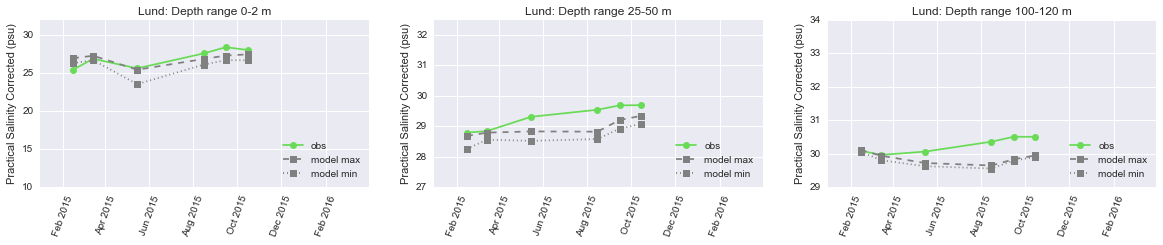

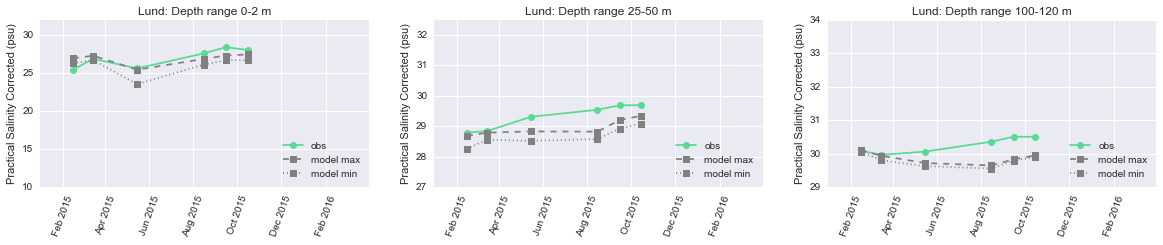

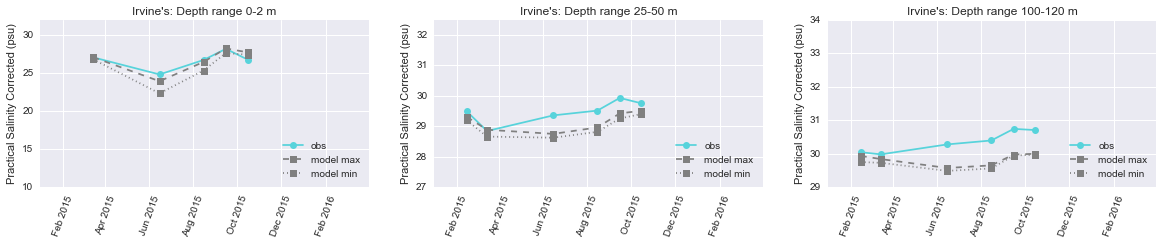

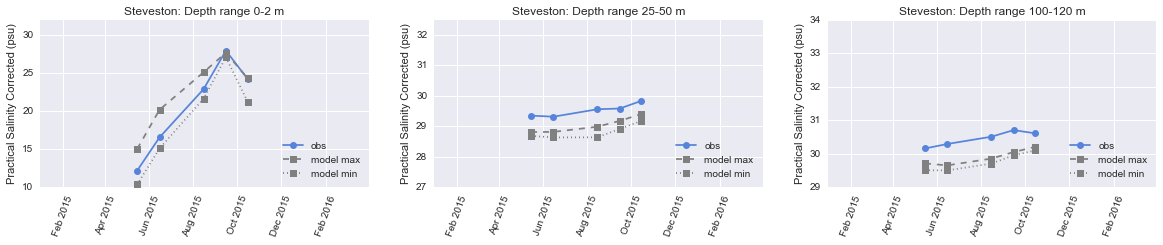

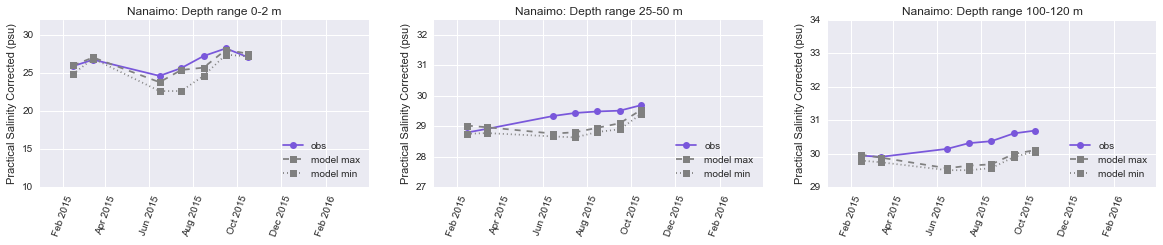

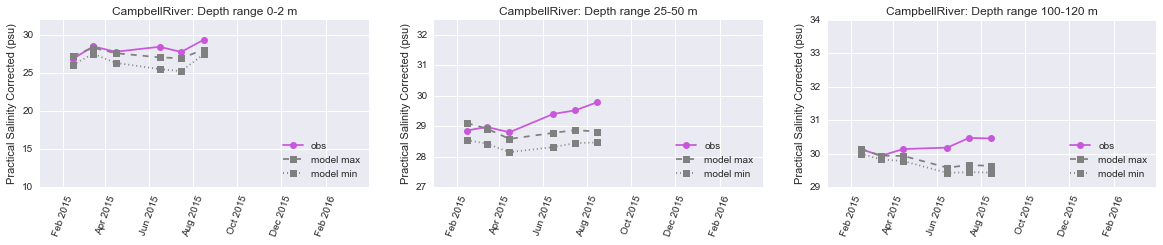

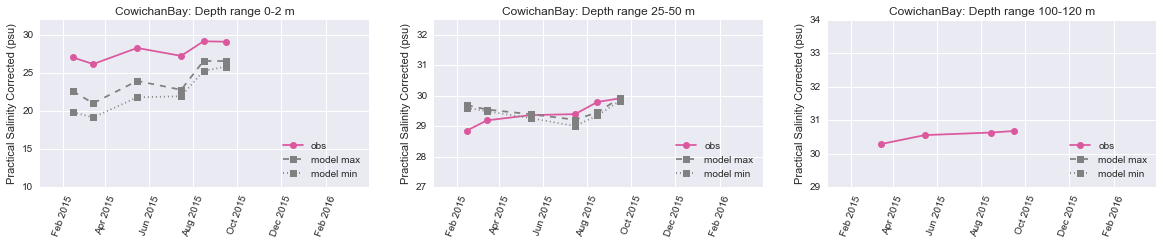

In [14]:
obs_field = 'Practical Salinity Corrected (psu)'
dranges = [ (0,2), (25,50), (100,120)]
lims=[(10,32), (27,32.5), (29,34)]
plot_region_by_region(obs_field, data_dict, dranges, lims, cols,files)

## Temperature

In [15]:
data_dict_temp =  process_all_model_obs_dict(files, 'votemper', 'Temperature Corrected (C)')

No Model Point for -124.86734926829268 49.60367543902441
No Model Point for -124.66473445454545 49.692539545454544
No Model Point for -123.30147711249997 48.334551287500005
No Model Point for -123.30579209999999 48.33254605
No Model Point for -123.18295900000003 48.461194
No Model Point for -123.44497209090906 48.3592954090909
No Model Point for -124.88309081132078 50.133188216981125
No Model Point for -124.88435187999998 50.02145567333332
No Model Point for -124.88373059333328 50.021488919999996
No Model Point for -124.8813384326241 50.13317171631203
No Model Point for -124.8818940066667 50.133191646666674
No Model Point for -124.92035517333338 49.92162987333333
No Model Point for -124.85466473333334 49.73138674999999
No Model Point for -124.92043986092716 49.92159999999987
No Model Point for -124.72611825675678 49.80339318243243
No Model Point for -124.92015144000004 49.921603720000014
No Model Point for -124.92028950335572 49.92159999999987
No Model Point for -124.15602561589404 49.

### Overview

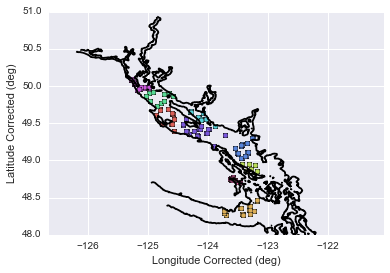

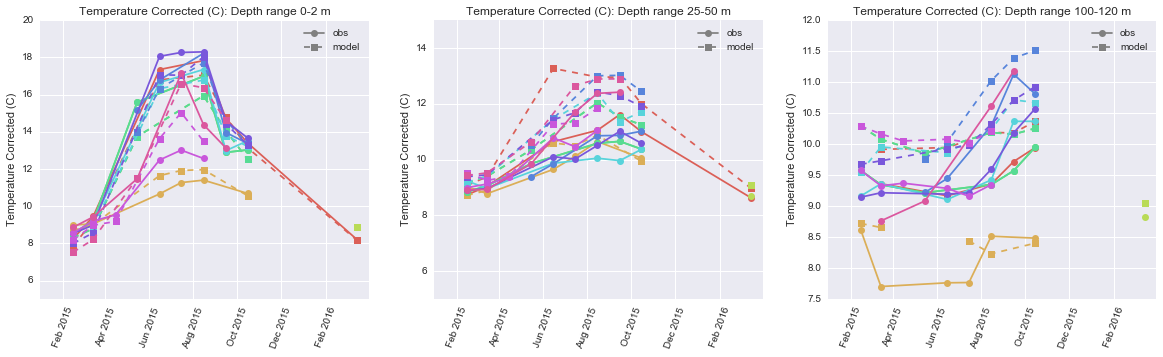

In [16]:
obs_field = 'Temperature Corrected (C)'
dranges = [ (0,2), (25,50), (100,120)]
lims=[(5,20), (5,15), (7.5,12)]
plot_overview(obs_field, data_dict_temp, dranges, lims, cols, grid_B,files)


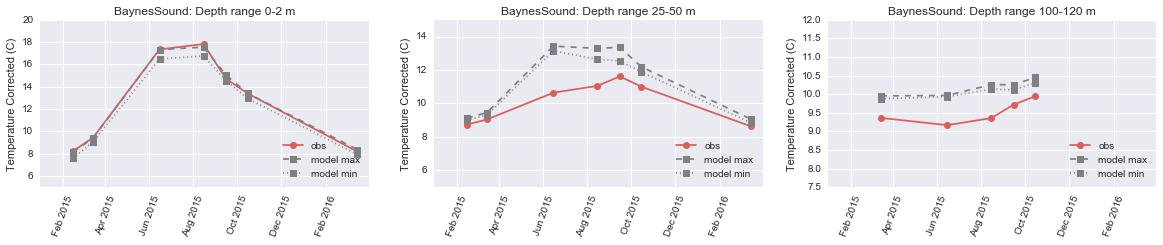

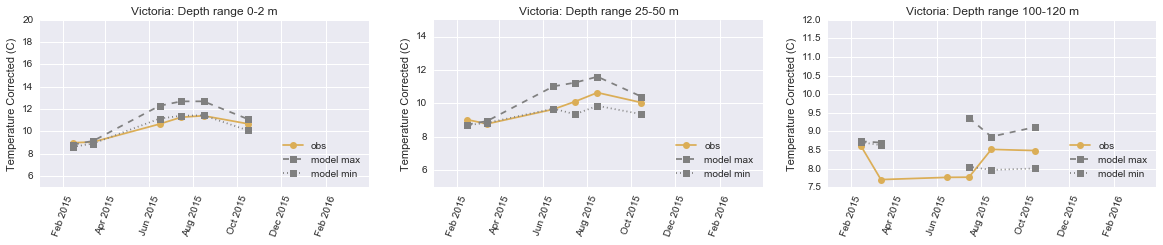

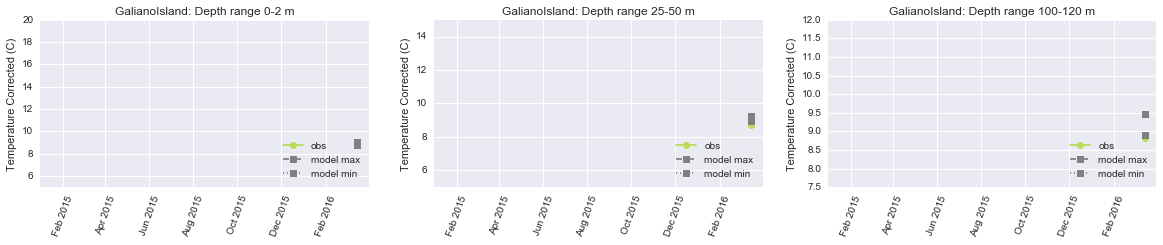

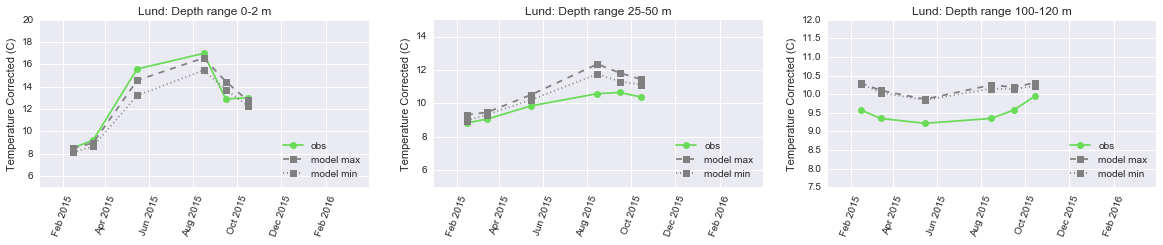

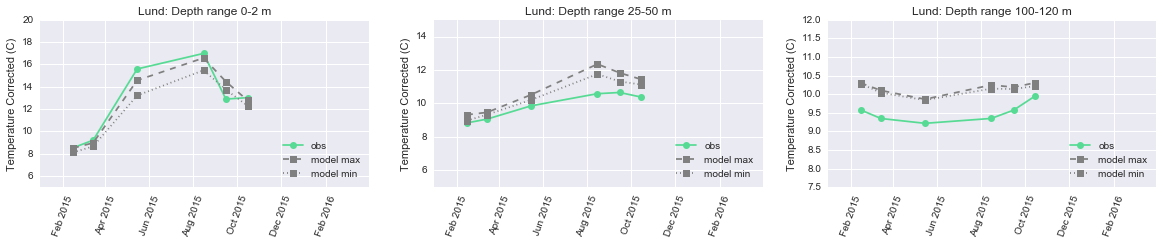

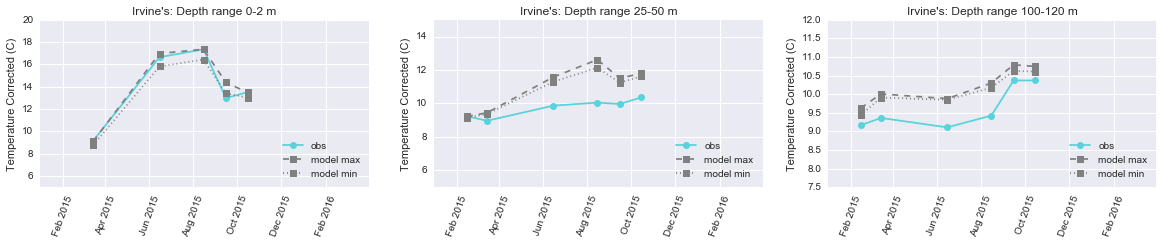

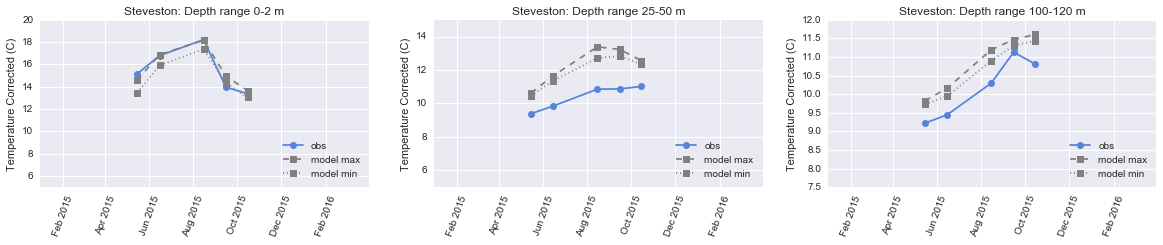

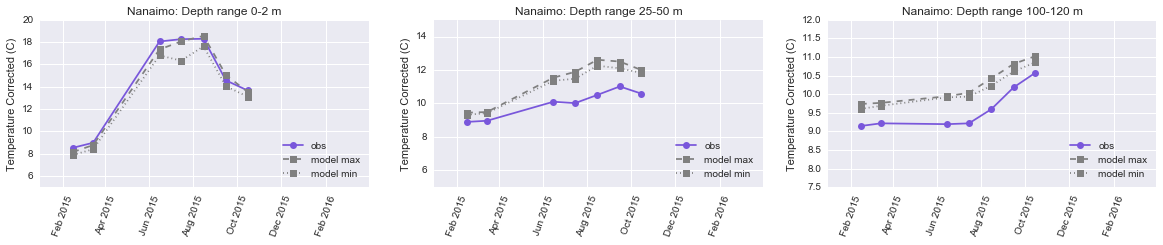

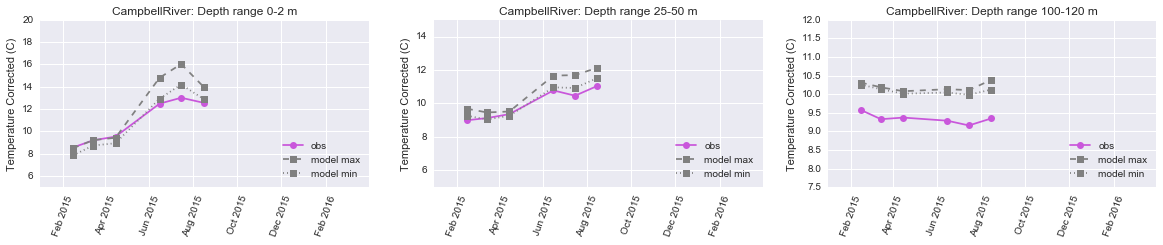

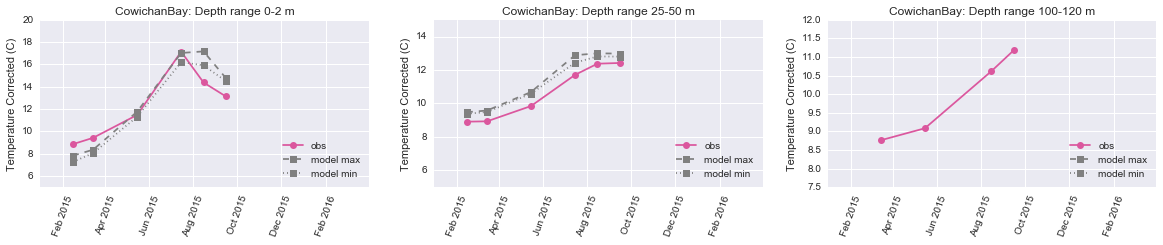

In [17]:
obs_field = 'Temperature Corrected (C)'
dranges = [ (0,2), (25,50), (100,120)]
lims=[(5,20), (5,15), (7.5,12)]
plot_region_by_region(obs_field, data_dict_temp, dranges, lims, cols,files)

* At depth (100-120m), the observed temperature and salinity increase over time in spring/summer months. The model does this too but the model timing of increased salinity is delayed but not for temperature.
* The model temperature at this depth range is too high.
* Victoria deep water is too warm from March to July - can this explain the temperature bias in the SoG? Notebook below says boundary conditions are too warm in the those months as well. 
* http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Nancy/strat/comparisons/JuandeFucaBCs.ipynb
* As we know, the model salinity is too low at depth. 